## Visualize the signature application results

Gregory Way, 2020

We applied three signatures of resistance in `2.apply-bulk-signatures.ipynb`.
Here, we visualize the results in training, test, and validation sets.

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))

In [2]:
seed <- 1234
set.seed(seed)

datasets <- c(
    "cloneAE" = "Bortezomib",
    "ixazomib" = "Ixazomib",
    "cb5083" = "CB-5083"
)

sig_dir <- file.path("results", "singscore")
results_file <- file.path(sig_dir, "full_bulk_signature_singscore_results.tsv.gz")

figure_dir <- file.path("figures", "singscore")

In [3]:
# Plotting options
legend_labels <- c(
    "training" = "Training",
    "test" = "Test",
    "validation" = "Validation"
)

legend_colors <- c(
    "training" = "#DAC19A",
    "test" = "#8EB2B1",
    "validation" = "#9F95B9"
)

In [4]:
sig_cols <- readr::cols(
    .default = readr::col_character(),
    Metadata_clone_type_indicator = readr::col_integer(),
    Metadata_plate_ID = readr::col_integer(),
    Metadata_celltype_shorthand_from_plate_graph = readr::col_integer(),
    Metadata_date = readr::col_integer(),
    Metadata_treatment_shorthand_from_plate_graph = readr::col_integer(),
    TotalScore = readr::col_double(),
    TotalDispersion = readr::col_double(),
    UpScore = readr::col_double(),
    UpDispersion = readr::col_double(),
    DownScore = readr::col_double(),
    DownDispersion = readr::col_double(),
    Metadata_permuted_p_value = readr::col_double(),
    min_permuted_value = readr::col_double(),
    max_permuted_value = readr::col_double()
)


signature_df <- readr::read_tsv(results_file, col_types = sig_cols)

print(dim(signature_df))
head(signature_df, 4)

[1] 1836   31


Metadata_Plate,Metadata_Well,Metadata_batch,Metadata_cell_count,Metadata_clone_number,Metadata_plate_map_name,Metadata_treatment,Metadata_dataset,Metadata_clone_type,Metadata_clone_type_indicator,⋯,TotalDispersion,UpScore,UpDispersion,DownScore,DownDispersion,Metadata_permuted_p_value,dataset,signature,min_permuted_value,max_permuted_value
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
HCT116bortezomib,B03,2019_02_15_Batch1_20X,16508,WT_parental,PlateMap_HCT116bortezomib,0.1% DMSO,cloneAE,sensitive,0,⋯,1859.1804,-0.07708926,1355.0964,-0.03398437,504.0840,0.799,cloneAE,cloneAE,-0.2259416,0.2257603
HCT116bortezomib,B04,2019_02_15_Batch1_20X,15536,WT_parental,PlateMap_HCT116bortezomib,0.1% DMSO,cloneAE,sensitive,0,⋯,1865.8521,-0.12589540,1313.5836,-0.01583807,552.2685,0.849,cloneAE,cloneAE,-0.2259416,0.2257603
HCT116bortezomib,B05,2019_02_15_Batch1_20X,13969,WT_parental,PlateMap_HCT116bortezomib,0.1% DMSO,cloneAE,sensitive,0,⋯,2093.4312,-0.03931211,1283.9316,0.04009233,809.4996,0.490,cloneAE,cloneAE,-0.2259416,0.2257603
HCT116bortezomib,B06,2019_02_15_Batch1_20X,13101,CloneA,PlateMap_HCT116bortezomib,0.1% DMSO,cloneAE,resistant,1,⋯,885.1122,0.23669699,406.9737,0.16054687,478.1385,0.002,cloneAE,cloneAE,-0.2259416,0.2257603


Warning message:
“Duplicated aesthetics after name standardisation: size”Warning message:
“Duplicated aesthetics after name standardisation: size”Warning message:
“Duplicated aesthetics after name standardisation: size”

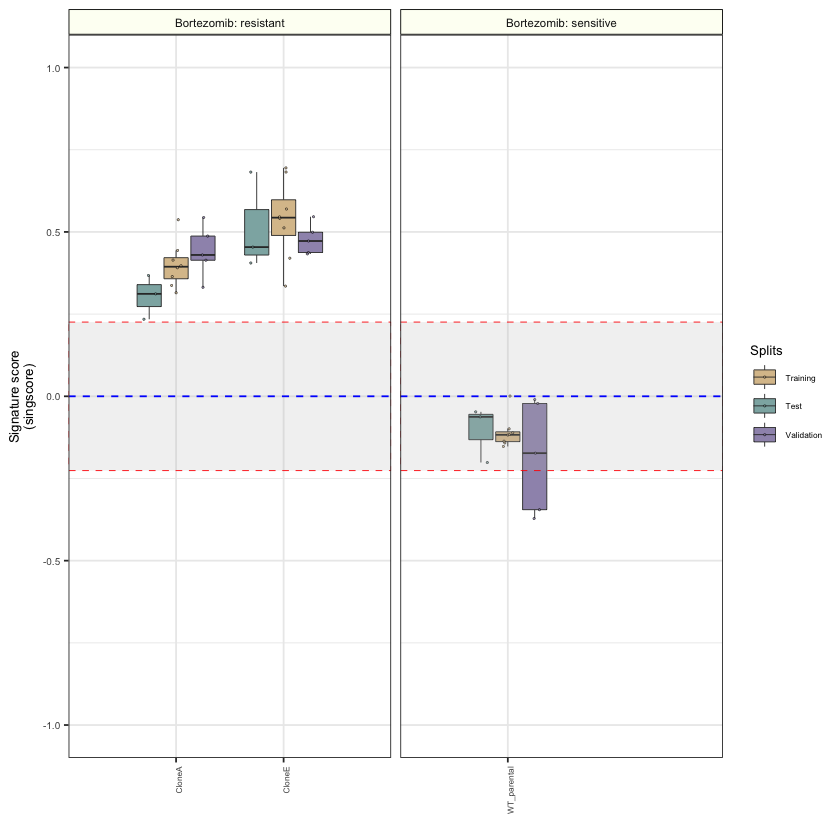

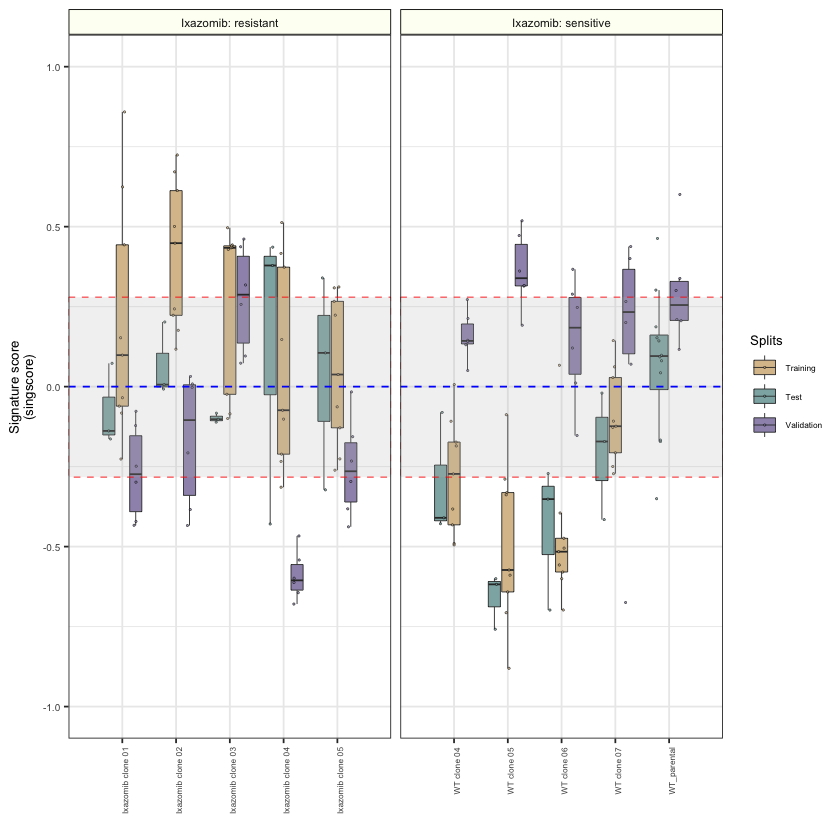

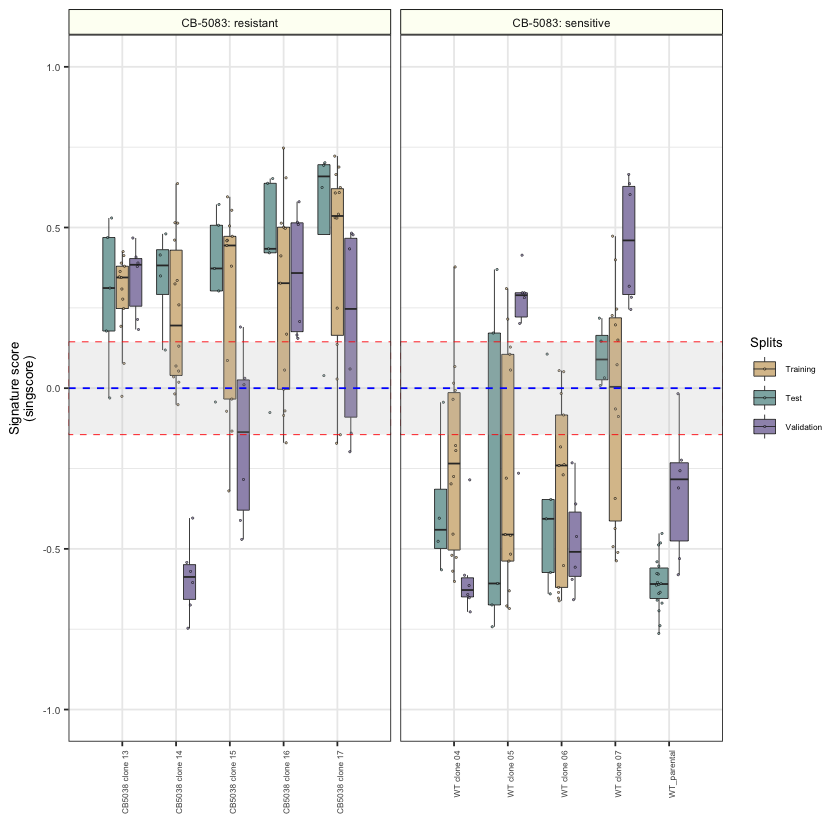

In [5]:
for (dataset in names(datasets)) {
    perturbation <- datasets[[dataset]]
    
    subset_signature_df <- signature_df %>%
        dplyr::filter(dataset == !!dataset, signature == !!dataset)
    
    append_sig <- function(string) paste0(perturbation, ": ", string)

    subset_signature_df <- signature_df %>%
        dplyr::filter(dataset == !!dataset, Metadata_model_split != "perturbation", signature == !!dataset)


    subset_signature_df$Metadata_model_split <- factor(
        subset_signature_df$Metadata_model_split, levels = c("training", "test", "validation")
    )

    min_val <- unique(subset_signature_df$min_permuted_value)
    max_val <- unique(subset_signature_df$max_permuted_value)

    results_gg <- (
        ggplot(subset_signature_df,
               aes(x = Metadata_clone_number,
                   y = TotalScore,
                   group = paste(Metadata_clone_number, Metadata_model_split))) +
        geom_boxplot(aes(fill = Metadata_model_split), lwd = 0.25, outlier.alpha = 0) +
        geom_jitter(position = position_jitterdodge(jitter.width = 0.3, dodge.width = 0.75),
                    aes(fill = Metadata_model_split),
                    stroke = 0.2,
                    size = 0.5,
                    alpha = 0.8,
                    shape = 21,
                    lwd = 0.25) +
        facet_wrap("~Metadata_clone_type",
                   ncol = 2,
                   scales = "free_x",
                   labeller = labeller(Metadata_clone_type = as_labeller(append_sig))) +
        xlab("") +
        ylab("Signature score\n(singscore)") +
        ylim(c(-1, 1)) +
        scale_fill_manual("Splits", values = legend_colors, labels = legend_labels) +
        theme_bw() +
        theme(
            legend.title = element_text(size = 8),
            legend.text = element_text(size = 5),
            axis.title = element_text(size = 8),
            axis.text.y = element_text(size = 6),
            axis.text.x = element_text(angle = 90, size = 5),
            strip.text = element_text(size = 7),
            strip.background = element_rect(colour="black", fill="#fdfff4")
        ) +
        annotate(
            "rect",
             ymin = min_val,
             ymax = max_val,
             xmin = 0,
             xmax = ceiling(length(unique(subset_signature_df$Metadata_clone_number)) / 2) + 1,
             alpha = 0.2,
             color = "red",
             linetype = "dashed",
             fill = "grey",
             lwd = 0.25
        ) +
        geom_hline(yintercept = 0, linetype = "dashed", color = "blue")
    )

    output_fig_file <- file.path(figure_dir, paste0("singscore_clone_results_", dataset, ".png"))
    ggsave(output_fig_file, results_gg, dpi = 500, height = 2.5, width = 5)
    
    print(results_gg)
}